# Dirt Normalisation

Notebook to extract the dirt normalisation factor needed for each run (2, 4a-d, 5)

This is very rudimentary. We use a single bin histogram of flash times during the spill window to determine how dirt should be scaled for best data-MC agreement.

In [129]:
import uproot3 as uproot 
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import joblib
import json

In [130]:
vars_to_load = ['flash_time']

In [131]:
loc_ntuple = '/exp/uboone/data/users/jbateman/workdir/HPS_uboone_analysis/Run_245_ana/'
run = 'Run4c'

with open('run_files.json') as file:
    run_file_pot_all = json.load(file)
    run_file_pot_dict = run_file_pot_all[run]

for file in run_file_pot_dict.keys():

    ntuple_name = run_file_pot_dict[file]['name']

    if file == 'Overlay' or file == 'Dirt':
        pot_df = uproot.open(loc_ntuple + ntuple_name+'.root')['nuselection/SubRun'].pandas.df()
        pot = pot_df['pot'].sum()
        run_file_pot_dict[file]['pot'] = pot
    
    ttree = uproot.open(loc_ntuple + ntuple_name+'.root')['nuselection/NeutrinoSelectionFilter'].pandas.df(vars_to_load)   
    run_file_pot_dict[file]['df'] = ttree



In [132]:
BeamOnTriggers_EA9CNT_wcut = run_file_pot_dict['Data']['triggers']
BeamOnPOT_tor101_wcut = run_file_pot_dict['Data']['pot']

BeamOffTriggers_EXT_NUMIwin_FEMBeamTriggerAlgo = run_file_pot_dict['Ext']['triggers']

overlay_pot = run_file_pot_dict['Overlay']['pot']

dirt_pot = run_file_pot_dict['Dirt']['pot']

scale_ext = BeamOnTriggers_EA9CNT_wcut / BeamOffTriggers_EXT_NUMIwin_FEMBeamTriggerAlgo
run_file_pot_dict['Ext']['scale_factor'] = scale_ext * 0.98
run_file_pot_dict['Overlay']['scale_factor'] = BeamOnPOT_tor101_wcut / overlay_pot
run_file_pot_dict['Dirt']['scale_factor'] = BeamOnPOT_tor101_wcut / dirt_pot



In [133]:
dirt_sf = 1.

Text(0.5, 1.0, 'Run4c')

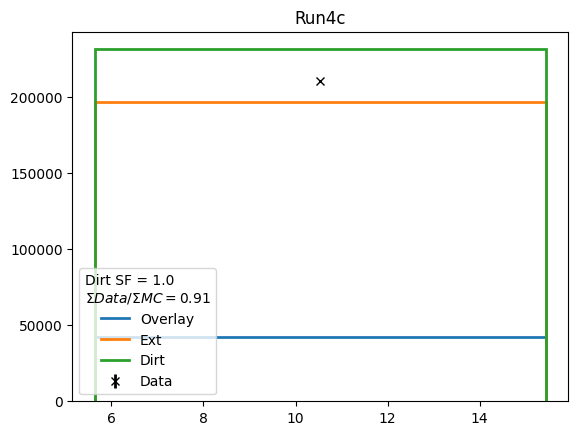

In [134]:
beam_window = (0, 25) # us
spill_window = (5.64, 15.44) # us

flash_time = spill_window

nbins = 1
bins = np.linspace(flash_time[0], flash_time[1], nbins+1)
tot_pred = np.zeros(nbins)

hist_dict = {}

for file in run_file_pot_dict.keys():
    if file != 'Data':
        flash_times = run_file_pot_dict[file]['df']['flash_time']

        # mask out vals > 1e37
        flash_times = flash_times[np.abs(flash_times) < 1e37]
        flash_hist, _ = np.histogram(flash_times, bins=bins)
        scaling = run_file_pot_dict[file]['scale_factor']
        if file == 'Dirt':
            scaling *= dirt_sf
        
        pred = flash_hist * scaling
        hist_dict[file] = pred
        tot_pred += pred

        plt.stairs(tot_pred, bins, label=file, alpha=1, lw=2)
    else:
        flash_times = run_file_pot_dict[file]['df']['flash_time']

        # mask out vals > 1e37
        flash_times = flash_times[np.abs(flash_times) < 1e37]
        flash_hist, _ = np.histogram(flash_times, bins=bins)
        
        hist_dict[file] = flash_hist

        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        plt.errorbar(bin_centers, flash_hist, yerr=np.sqrt(flash_hist), label=file, color='k', fmt='x', alpha=1, lw=2)

data_bkg_ratio = sum(hist_dict['Data']) / sum(tot_pred)
plt.legend(loc='lower left',title=f'Dirt SF = {dirt_sf:.2}\n' rf'$\Sigma Data / \Sigma MC=$'+ f'{data_bkg_ratio:.2f}')
plt.title(run)

In [126]:
def get_dirt_scale_factor(data_hist, dirt_hist, other_bkg_hist):
    """
    Function to get the dirt scale factor to optimise MC-data agreement.
    """
    # Get the dirt-only contribtion
    dirt_only = data_hist - other_bkg_hist
    # Calculate the scale factor
    dirt_sf = np.sum(dirt_only) / np.sum(dirt_hist)
    return dirt_sf

In [127]:
data_hist = hist_dict['Data']
dirt_hist = hist_dict['Dirt']
other_bkg_hist = hist_dict['Overlay'] + hist_dict['Ext']
dirt_sf = get_dirt_scale_factor(data_hist, dirt_hist, other_bkg_hist)
print(f'Dirt scale factor: {dirt_sf:.2f}')

Dirt scale factor: 0.40


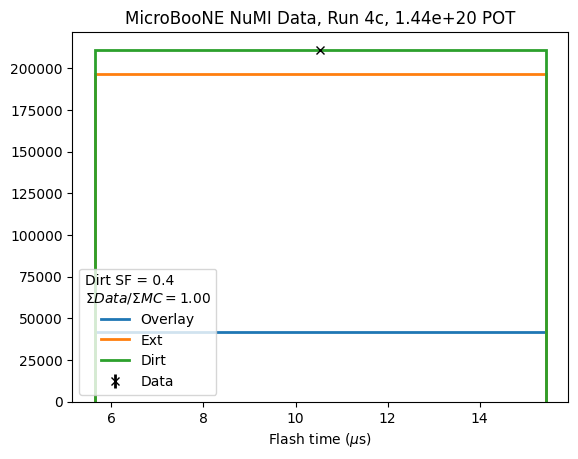

In [128]:
beam_window = (0, 25) # us
spill_window = (5.64, 15.44) # us

flash_time = spill_window

nbins = 1
bins = np.linspace(flash_time[0], flash_time[1], nbins+1)
tot_pred = np.zeros(nbins)

hist_dict = {}

for file in run_file_pot_dict.keys():
    if file != 'Data':
        flash_times = run_file_pot_dict[file]['df']['flash_time']

        # mask out vals > 1e37
        flash_times = flash_times[np.abs(flash_times) < 1e37]
        flash_hist, _ = np.histogram(flash_times, bins=bins)
        scaling = run_file_pot_dict[file]['scale_factor']
        if file == 'Dirt':
            scaling *= dirt_sf
        
        pred = flash_hist * scaling
        hist_dict[file] = pred
        tot_pred += pred

        plt.stairs(tot_pred, bins, label=file, alpha=1, lw=2)
    else:
        flash_times = run_file_pot_dict[file]['df']['flash_time']

        # mask out vals > 1e37
        flash_times = flash_times[np.abs(flash_times) < 1e37]
        flash_hist, _ = np.histogram(flash_times, bins=bins)
        
        hist_dict[file] = flash_hist

        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        plt.errorbar(bin_centers, flash_hist, yerr=np.sqrt(flash_hist), label=file, color='k', fmt='x', alpha=1, lw=2)

data_bkg_ratio = sum(hist_dict['Data']) / sum(tot_pred)
plt.legend(loc='lower left',title=f'Dirt SF = {dirt_sf:.2}\n' rf'$\Sigma Data / \Sigma MC=$'+ f'{data_bkg_ratio:.2f}')
run_number = run.split('Run')[1]
plt.title(f'MicroBooNE NuMI Data, Run {run_number}, {BeamOnPOT_tor101_wcut:.2e} POT')
plt.xlabel(rf'Flash time ($\mu$s)')
plt.show()